In [1]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/b0/be/3db3cd8af771988748f69eace42047d5edebf01eaa7e1293f3b3f75f989e/albumentations-1.0.0-py3-none-any.whl
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [2]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.insert(0,'/content/drive')

In [6]:
%cd /content/drive/My\ Drive
from model import Net

/content/drive/My Drive


In [7]:
from model import Net 

In [8]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=12, max_width=12, min_holes = 1, min_height=1, min_width=1, fill_value=0.5, mask_fill_value = None),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
    ]
)

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
'''
trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=transform)
test_loader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 deer   car horse   dog


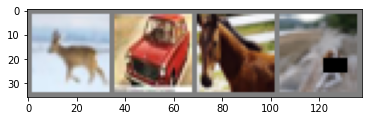

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [11]:
net = Net()

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
            Conv2d-2           [-1, 32, 32, 32]           4,608
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]              96
            Conv2d-7           [-1, 64, 15, 15]          18,432
            Conv2d-8          [-1, 128, 15, 15]          73,728
       BatchNorm2d-9          [-1, 128, 15, 15]             256
             ReLU-10          [-1, 128, 15, 15]               0
          Dropout-11          [-1, 128, 15, 15]               0
           Conv2d-12           [-1, 64, 11, 11]          73,728
           Conv2d-13             [-1, 32, 9, 9]          18,432
      BatchNorm2d-14             [

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [13]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [14]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [15]:
from tqdm import tqdm




def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    #train_losses.append(loss)
    train_loss = train_loss + loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader.dataset)
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss)
  #train_losses.append(loss)

    #return train_acc, train_losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
def display_misclassified_images(model):
  print("\n\n\n********* Misclassified Images **************\n\n\n")
  model.eval()

  # Create a test loader with batch size equal to test data length
  #test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=transform)
  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          # Get the indexes of images that are incorrectly classified
          indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

          # Plot the misclassified images
          rows = np.ceil(len(indexes)/2)
          fig = plt.figure(figsize=(15, rows*4))
          for i, idx in enumerate(indexes[:10]):
              ax = fig.add_subplot(rows, 5, i+1)
              ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r',dpi=100)
              ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
          
          plt.show()

In [17]:
#def train_test_display(no_of_epochs):
EPOCHS = 120

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#learning_rate = 0.01
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# LR Scheduler
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

for epoch in range(1,EPOCHS +1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    optimizer.step()
    test(model, device, test_loader)

#display_misclassified_images(model)

#return test_acc, test_losses,train_acc,train_losses

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.295235514640808 Batch_id=390 Accuracy=38.16: 100%|██████████| 391/391 [00:11<00:00, 35.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 3896/10000 (38.96%)

EPOCH: 2


Loss=1.1689974069595337 Batch_id=390 Accuracy=53.57: 100%|██████████| 391/391 [00:11<00:00, 35.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5336/10000 (53.36%)

EPOCH: 3


Loss=0.9177452325820923 Batch_id=390 Accuracy=60.79: 100%|██████████| 391/391 [00:10<00:00, 36.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 6032/10000 (60.32%)

EPOCH: 4


Loss=1.036061406135559 Batch_id=390 Accuracy=65.13: 100%|██████████| 391/391 [00:11<00:00, 35.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6391/10000 (63.91%)

EPOCH: 5


Loss=0.8584557771682739 Batch_id=390 Accuracy=68.08: 100%|██████████| 391/391 [00:10<00:00, 36.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7066/10000 (70.66%)

EPOCH: 6


Loss=0.704724907875061 Batch_id=390 Accuracy=70.17: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7009/10000 (70.09%)

EPOCH: 7


Loss=0.9283041954040527 Batch_id=390 Accuracy=71.75: 100%|██████████| 391/391 [00:11<00:00, 34.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6834/10000 (68.34%)

EPOCH: 8


Loss=0.6756020784378052 Batch_id=390 Accuracy=73.23: 100%|██████████| 391/391 [00:10<00:00, 35.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7076/10000 (70.76%)

EPOCH: 9


Loss=0.7234519720077515 Batch_id=390 Accuracy=73.79: 100%|██████████| 391/391 [00:10<00:00, 35.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7591/10000 (75.91%)

EPOCH: 10


Loss=0.7254109382629395 Batch_id=390 Accuracy=74.87: 100%|██████████| 391/391 [00:11<00:00, 34.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6989/10000 (69.89%)

EPOCH: 11


Loss=0.6327402591705322 Batch_id=390 Accuracy=75.63: 100%|██████████| 391/391 [00:10<00:00, 35.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7602/10000 (76.02%)

EPOCH: 12


Loss=0.5678415298461914 Batch_id=390 Accuracy=76.69: 100%|██████████| 391/391 [00:11<00:00, 34.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7556/10000 (75.56%)

EPOCH: 13


Loss=0.7304637432098389 Batch_id=390 Accuracy=76.97: 100%|██████████| 391/391 [00:11<00:00, 35.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7391/10000 (73.91%)

EPOCH: 14


Loss=0.6317557692527771 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [00:10<00:00, 35.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7642/10000 (76.42%)

EPOCH: 15


Loss=0.6578431725502014 Batch_id=390 Accuracy=78.29: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7597/10000 (75.97%)

EPOCH: 16


Loss=0.5464463233947754 Batch_id=390 Accuracy=78.48: 100%|██████████| 391/391 [00:11<00:00, 35.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7768/10000 (77.68%)

EPOCH: 17


Loss=1.0461063385009766 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [00:11<00:00, 35.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7758/10000 (77.58%)

EPOCH: 18


Loss=0.7393178343772888 Batch_id=390 Accuracy=79.29: 100%|██████████| 391/391 [00:10<00:00, 36.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7865/10000 (78.65%)

EPOCH: 19


Loss=0.6765477657318115 Batch_id=390 Accuracy=79.69: 100%|██████████| 391/391 [00:10<00:00, 35.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7942/10000 (79.42%)

EPOCH: 20


Loss=0.5038326382637024 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [00:10<00:00, 36.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7791/10000 (77.91%)

EPOCH: 21


Loss=0.38967493176460266 Batch_id=390 Accuracy=80.17: 100%|██████████| 391/391 [00:10<00:00, 35.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7873/10000 (78.73%)

EPOCH: 22


Loss=0.7028847932815552 Batch_id=390 Accuracy=80.53: 100%|██████████| 391/391 [00:11<00:00, 34.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7915/10000 (79.15%)

EPOCH: 23


Loss=0.5855306386947632 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:11<00:00, 35.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7868/10000 (78.68%)

EPOCH: 24


Loss=0.5871798992156982 Batch_id=390 Accuracy=81.02: 100%|██████████| 391/391 [00:11<00:00, 35.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8047/10000 (80.47%)

EPOCH: 25


Loss=0.5738135576248169 Batch_id=390 Accuracy=81.39: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7936/10000 (79.36%)

EPOCH: 26


Loss=0.5232061743736267 Batch_id=390 Accuracy=81.63: 100%|██████████| 391/391 [00:11<00:00, 35.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7895/10000 (78.95%)

EPOCH: 27


Loss=0.6783434748649597 Batch_id=390 Accuracy=81.59: 100%|██████████| 391/391 [00:11<00:00, 34.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8170/10000 (81.70%)

EPOCH: 28


Loss=0.36840471625328064 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:11<00:00, 34.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8091/10000 (80.91%)

EPOCH: 29


Loss=0.35609883069992065 Batch_id=390 Accuracy=82.12: 100%|██████████| 391/391 [00:11<00:00, 35.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8013/10000 (80.13%)

EPOCH: 30


Loss=0.5832308530807495 Batch_id=390 Accuracy=82.40: 100%|██████████| 391/391 [00:11<00:00, 34.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8045/10000 (80.45%)

EPOCH: 31


Loss=0.5580507516860962 Batch_id=390 Accuracy=82.37: 100%|██████████| 391/391 [00:11<00:00, 34.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8068/10000 (80.68%)

EPOCH: 32


Loss=0.4471321702003479 Batch_id=390 Accuracy=82.65: 100%|██████████| 391/391 [00:11<00:00, 35.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8078/10000 (80.78%)

EPOCH: 33


Loss=0.46143627166748047 Batch_id=390 Accuracy=82.97: 100%|██████████| 391/391 [00:11<00:00, 34.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8190/10000 (81.90%)

EPOCH: 34


Loss=0.44791287183761597 Batch_id=390 Accuracy=83.06: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8167/10000 (81.67%)

EPOCH: 35


Loss=0.3347686231136322 Batch_id=390 Accuracy=83.10: 100%|██████████| 391/391 [00:11<00:00, 34.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8261/10000 (82.61%)

EPOCH: 36


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8108/10000 (81.08%)

EPOCH: 37


Loss=0.4640042781829834 Batch_id=390 Accuracy=83.54: 100%|██████████| 391/391 [00:11<00:00, 34.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8177/10000 (81.77%)

EPOCH: 38


Loss=0.46325787901878357 Batch_id=390 Accuracy=83.50: 100%|██████████| 391/391 [00:11<00:00, 33.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8225/10000 (82.25%)

EPOCH: 39


Loss=0.5455237627029419 Batch_id=390 Accuracy=83.56: 100%|██████████| 391/391 [00:11<00:00, 34.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8239/10000 (82.39%)

EPOCH: 40


Loss=0.5327123403549194 Batch_id=390 Accuracy=83.82: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8160/10000 (81.60%)

EPOCH: 41


Loss=0.502548098564148 Batch_id=390 Accuracy=83.76: 100%|██████████| 391/391 [00:11<00:00, 34.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8138/10000 (81.38%)

EPOCH: 42


Loss=0.33445900678634644 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [00:11<00:00, 34.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8243/10000 (82.43%)

EPOCH: 43


Loss=0.48713016510009766 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:11<00:00, 34.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8273/10000 (82.73%)

EPOCH: 44


Loss=0.3313067853450775 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [00:11<00:00, 34.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8277/10000 (82.77%)

EPOCH: 45


Loss=0.4177541732788086 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:11<00:00, 34.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8352/10000 (83.52%)

EPOCH: 46


Loss=0.4659470021724701 Batch_id=390 Accuracy=84.60: 100%|██████████| 391/391 [00:11<00:00, 34.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8271/10000 (82.71%)

EPOCH: 47


Loss=0.4017537534236908 Batch_id=390 Accuracy=84.57: 100%|██████████| 391/391 [00:11<00:00, 34.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8293/10000 (82.93%)

EPOCH: 48


Loss=0.3294336199760437 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [00:11<00:00, 34.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8310/10000 (83.10%)

EPOCH: 49


Loss=0.37897783517837524 Batch_id=390 Accuracy=84.75: 100%|██████████| 391/391 [00:11<00:00, 34.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8343/10000 (83.43%)

EPOCH: 50


Loss=0.48350295424461365 Batch_id=390 Accuracy=84.90: 100%|██████████| 391/391 [00:11<00:00, 34.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8276/10000 (82.76%)

EPOCH: 51


Loss=0.6167230606079102 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [00:11<00:00, 34.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8396/10000 (83.96%)

EPOCH: 52


Loss=0.5325517058372498 Batch_id=390 Accuracy=85.05: 100%|██████████| 391/391 [00:11<00:00, 34.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8271/10000 (82.71%)

EPOCH: 53


Loss=0.3825296461582184 Batch_id=390 Accuracy=84.98: 100%|██████████| 391/391 [00:11<00:00, 33.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8310/10000 (83.10%)

EPOCH: 54


Loss=0.4814698100090027 Batch_id=390 Accuracy=85.04: 100%|██████████| 391/391 [00:11<00:00, 34.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8283/10000 (82.83%)

EPOCH: 55


Loss=0.3680252730846405 Batch_id=390 Accuracy=85.19: 100%|██████████| 391/391 [00:11<00:00, 34.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8301/10000 (83.01%)

EPOCH: 56


Loss=0.5706387758255005 Batch_id=390 Accuracy=85.37: 100%|██████████| 391/391 [00:11<00:00, 33.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8192/10000 (81.92%)

EPOCH: 57


Loss=0.38021788001060486 Batch_id=390 Accuracy=85.78: 100%|██████████| 391/391 [00:11<00:00, 34.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8403/10000 (84.03%)

EPOCH: 58


Loss=0.4765831530094147 Batch_id=390 Accuracy=85.47: 100%|██████████| 391/391 [00:11<00:00, 33.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8323/10000 (83.23%)

EPOCH: 59


Loss=0.4548388421535492 Batch_id=390 Accuracy=85.53: 100%|██████████| 391/391 [00:11<00:00, 34.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8346/10000 (83.46%)

EPOCH: 60


Loss=0.3548377454280853 Batch_id=390 Accuracy=85.81: 100%|██████████| 391/391 [00:11<00:00, 34.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8404/10000 (84.04%)

EPOCH: 61


Loss=0.4346257150173187 Batch_id=390 Accuracy=85.93: 100%|██████████| 391/391 [00:11<00:00, 33.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8369/10000 (83.69%)

EPOCH: 62


Loss=0.4808126986026764 Batch_id=390 Accuracy=85.79: 100%|██████████| 391/391 [00:11<00:00, 34.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8380/10000 (83.80%)

EPOCH: 63


Loss=0.3505081832408905 Batch_id=390 Accuracy=85.80: 100%|██████████| 391/391 [00:11<00:00, 33.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8403/10000 (84.03%)

EPOCH: 64


Loss=0.6761592030525208 Batch_id=390 Accuracy=85.97: 100%|██████████| 391/391 [00:11<00:00, 34.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8416/10000 (84.16%)

EPOCH: 65


Loss=0.3512318730354309 Batch_id=390 Accuracy=86.11: 100%|██████████| 391/391 [00:11<00:00, 34.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8397/10000 (83.97%)

EPOCH: 66


Loss=0.32902079820632935 Batch_id=390 Accuracy=86.00: 100%|██████████| 391/391 [00:11<00:00, 33.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8438/10000 (84.38%)

EPOCH: 67


Loss=0.4242996573448181 Batch_id=390 Accuracy=85.98: 100%|██████████| 391/391 [00:11<00:00, 33.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8466/10000 (84.66%)

EPOCH: 68


Loss=0.5155261158943176 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [00:11<00:00, 34.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8402/10000 (84.02%)

EPOCH: 69


Loss=0.4264773428440094 Batch_id=390 Accuracy=86.30: 100%|██████████| 391/391 [00:11<00:00, 33.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8369/10000 (83.69%)

EPOCH: 70


Loss=0.44077444076538086 Batch_id=390 Accuracy=86.59: 100%|██████████| 391/391 [00:11<00:00, 34.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

EPOCH: 71


Loss=0.516568124294281 Batch_id=390 Accuracy=86.54: 100%|██████████| 391/391 [00:11<00:00, 33.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8332/10000 (83.32%)

EPOCH: 72


Loss=0.42324113845825195 Batch_id=390 Accuracy=86.64: 100%|██████████| 391/391 [00:11<00:00, 33.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8460/10000 (84.60%)

EPOCH: 73


Loss=0.4230732023715973 Batch_id=390 Accuracy=86.53: 100%|██████████| 391/391 [00:11<00:00, 33.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8437/10000 (84.37%)

EPOCH: 74


Loss=0.477230966091156 Batch_id=390 Accuracy=86.71: 100%|██████████| 391/391 [00:11<00:00, 33.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8431/10000 (84.31%)

EPOCH: 75


Loss=0.47037920355796814 Batch_id=390 Accuracy=86.53: 100%|██████████| 391/391 [00:11<00:00, 33.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8386/10000 (83.86%)

EPOCH: 76


Loss=0.3160772919654846 Batch_id=390 Accuracy=86.89: 100%|██████████| 391/391 [00:11<00:00, 33.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8383/10000 (83.83%)

EPOCH: 77


Loss=0.4259626865386963 Batch_id=390 Accuracy=86.92: 100%|██████████| 391/391 [00:11<00:00, 33.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8399/10000 (83.99%)

EPOCH: 78


Loss=0.3378659188747406 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:11<00:00, 33.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8387/10000 (83.87%)

EPOCH: 79


Loss=0.4901576638221741 Batch_id=390 Accuracy=86.85: 100%|██████████| 391/391 [00:11<00:00, 33.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8458/10000 (84.58%)

EPOCH: 80


Loss=0.611228883266449 Batch_id=390 Accuracy=86.96: 100%|██████████| 391/391 [00:11<00:00, 33.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8369/10000 (83.69%)

EPOCH: 81


Loss=0.41514724493026733 Batch_id=390 Accuracy=86.92: 100%|██████████| 391/391 [00:11<00:00, 33.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8429/10000 (84.29%)

EPOCH: 82


Loss=0.3558797240257263 Batch_id=390 Accuracy=87.14: 100%|██████████| 391/391 [00:11<00:00, 33.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8468/10000 (84.68%)

EPOCH: 83


Loss=0.36272481083869934 Batch_id=390 Accuracy=86.83: 100%|██████████| 391/391 [00:11<00:00, 33.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)

EPOCH: 84


Loss=0.3807451128959656 Batch_id=390 Accuracy=87.15: 100%|██████████| 391/391 [00:11<00:00, 33.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8422/10000 (84.22%)

EPOCH: 85


Loss=0.45526137948036194 Batch_id=390 Accuracy=87.37: 100%|██████████| 391/391 [00:11<00:00, 33.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8427/10000 (84.27%)

EPOCH: 86


Loss=0.4190923273563385 Batch_id=390 Accuracy=87.06: 100%|██████████| 391/391 [00:11<00:00, 33.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8487/10000 (84.87%)

EPOCH: 87


Loss=0.4219086170196533 Batch_id=390 Accuracy=87.46: 100%|██████████| 391/391 [00:11<00:00, 33.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8497/10000 (84.97%)

EPOCH: 88


Loss=0.33344408869743347 Batch_id=390 Accuracy=87.32: 100%|██████████| 391/391 [00:11<00:00, 33.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8443/10000 (84.43%)

EPOCH: 89


Loss=0.38139718770980835 Batch_id=390 Accuracy=87.66: 100%|██████████| 391/391 [00:11<00:00, 33.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8478/10000 (84.78%)

EPOCH: 90


Loss=0.4169115424156189 Batch_id=390 Accuracy=87.61: 100%|██████████| 391/391 [00:11<00:00, 32.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8432/10000 (84.32%)

EPOCH: 91


Loss=0.3819900155067444 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:11<00:00, 32.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 92


Loss=0.5426164865493774 Batch_id=390 Accuracy=87.51: 100%|██████████| 391/391 [00:11<00:00, 32.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8420/10000 (84.20%)

EPOCH: 93


Loss=0.3749532103538513 Batch_id=390 Accuracy=87.68: 100%|██████████| 391/391 [00:12<00:00, 32.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8424/10000 (84.24%)

EPOCH: 94


Loss=0.3072231709957123 Batch_id=390 Accuracy=87.46: 100%|██████████| 391/391 [00:11<00:00, 33.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8466/10000 (84.66%)

EPOCH: 95


Loss=0.38191062211990356 Batch_id=390 Accuracy=87.70: 100%|██████████| 391/391 [00:12<00:00, 32.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8529/10000 (85.29%)

EPOCH: 96


Loss=0.4924755096435547 Batch_id=390 Accuracy=87.58: 100%|██████████| 391/391 [00:11<00:00, 33.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8496/10000 (84.96%)

EPOCH: 97


Loss=0.36156272888183594 Batch_id=390 Accuracy=87.71: 100%|██████████| 391/391 [00:11<00:00, 33.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8480/10000 (84.80%)

EPOCH: 98


Loss=0.197369784116745 Batch_id=390 Accuracy=87.77: 100%|██████████| 391/391 [00:11<00:00, 32.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8528/10000 (85.28%)

EPOCH: 99


Loss=0.3536836504936218 Batch_id=390 Accuracy=87.85: 100%|██████████| 391/391 [00:11<00:00, 32.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8439/10000 (84.39%)

EPOCH: 100


Loss=0.32062211632728577 Batch_id=390 Accuracy=87.88: 100%|██████████| 391/391 [00:11<00:00, 33.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8340/10000 (83.40%)

EPOCH: 101


Loss=0.4040824770927429 Batch_id=390 Accuracy=87.79: 100%|██████████| 391/391 [00:12<00:00, 32.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8520/10000 (85.20%)

EPOCH: 102


Loss=0.47953763604164124 Batch_id=390 Accuracy=88.01: 100%|██████████| 391/391 [00:11<00:00, 33.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8489/10000 (84.89%)

EPOCH: 103


Loss=0.2799322307109833 Batch_id=390 Accuracy=87.85: 100%|██████████| 391/391 [00:12<00:00, 32.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 104


Loss=0.4462054371833801 Batch_id=390 Accuracy=88.04: 100%|██████████| 391/391 [00:11<00:00, 33.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8500/10000 (85.00%)

EPOCH: 105


Loss=0.2990402281284332 Batch_id=390 Accuracy=87.99: 100%|██████████| 391/391 [00:11<00:00, 32.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8469/10000 (84.69%)

EPOCH: 106


Loss=0.42559075355529785 Batch_id=390 Accuracy=88.26: 100%|██████████| 391/391 [00:12<00:00, 32.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8492/10000 (84.92%)

EPOCH: 107


Loss=0.3910113573074341 Batch_id=390 Accuracy=88.14: 100%|██████████| 391/391 [00:11<00:00, 32.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8505/10000 (85.05%)

EPOCH: 108


Loss=0.24222251772880554 Batch_id=390 Accuracy=88.04: 100%|██████████| 391/391 [00:11<00:00, 33.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8539/10000 (85.39%)

EPOCH: 109


Loss=0.5800142288208008 Batch_id=390 Accuracy=87.87: 100%|██████████| 391/391 [00:11<00:00, 32.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8435/10000 (84.35%)

EPOCH: 110


Loss=0.29745742678642273 Batch_id=390 Accuracy=88.19: 100%|██████████| 391/391 [00:12<00:00, 32.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8484/10000 (84.84%)

EPOCH: 111


Loss=0.3240489959716797 Batch_id=390 Accuracy=88.43: 100%|██████████| 391/391 [00:11<00:00, 32.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8425/10000 (84.25%)

EPOCH: 112


Loss=0.47504204511642456 Batch_id=390 Accuracy=88.19: 100%|██████████| 391/391 [00:12<00:00, 32.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8449/10000 (84.49%)

EPOCH: 113


Loss=0.5028195381164551 Batch_id=390 Accuracy=88.07: 100%|██████████| 391/391 [00:11<00:00, 33.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8479/10000 (84.79%)

EPOCH: 114


Loss=0.410590797662735 Batch_id=390 Accuracy=87.94: 100%|██████████| 391/391 [00:11<00:00, 32.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8546/10000 (85.46%)

EPOCH: 115


Loss=0.3589091897010803 Batch_id=390 Accuracy=88.31: 100%|██████████| 391/391 [00:11<00:00, 32.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8494/10000 (84.94%)

EPOCH: 116


Loss=0.26516464352607727 Batch_id=390 Accuracy=88.51: 100%|██████████| 391/391 [00:11<00:00, 32.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8476/10000 (84.76%)

EPOCH: 117


Loss=0.2963624596595764 Batch_id=390 Accuracy=88.37: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8408/10000 (84.08%)

EPOCH: 118


Loss=0.3184296786785126 Batch_id=390 Accuracy=88.33: 100%|██████████| 391/391 [00:11<00:00, 32.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8512/10000 (85.12%)

EPOCH: 119


Loss=0.3319458067417145 Batch_id=390 Accuracy=88.40: 100%|██████████| 391/391 [00:12<00:00, 32.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8431/10000 (84.31%)

EPOCH: 120


Loss=0.23787613213062286 Batch_id=390 Accuracy=88.58: 100%|██████████| 391/391 [00:12<00:00, 32.17it/s]



Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)



In [18]:

#test_acc_f, test_losses_f,train_acc_f,train_losses_f = train_test_display(EPOCHS)

Text(0.5, 1.0, 'Loss')

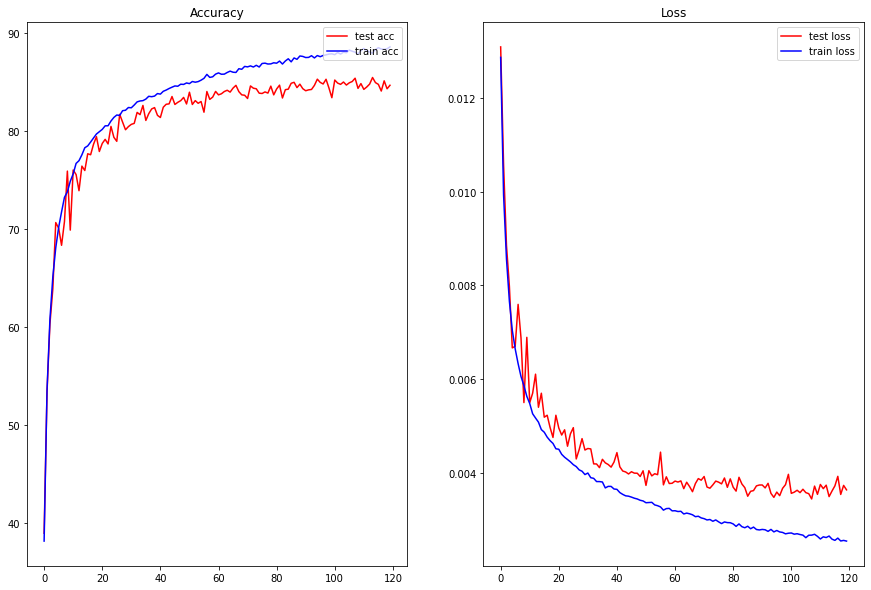

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs =[x for x in range(EPOCHS)]
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(epochs,test_acc,'-r',label='test acc')
axs[0].plot(epochs,train_acc,'-b',label='train acc')
axs[0].legend(loc="upper right")
axs[0].set_title("Accuracy")

epochs =[x for x in range(EPOCHS)]
axs[1].plot(epochs,test_losses,'r',label='test loss')
axs[1].plot(epochs,train_losses,'b',label='train loss')
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")